#  1. Data information


listings.csv - summary information on listing in Seattle such as: location, host information, cleaning and guest fees, amenities etc.

calendar.csv - calendar data for the listings: availability dates, price for each date.

reviews.csv - summary review data for the listings. This dataset won't be used in further analysis.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
calendar_DF = pd.read_csv("calendar.csv")

In [3]:
listings = pd.read_csv("listings.csv")

In [4]:
reviews = pd.read_csv("reviews.csv")

# 2. Prepare and explore data 


Before gather necessary data to answer my questions, I need to 

(1) handle categorical and missing data. In these datasets, there are so many missing values which need to be removed. 

(2) Dates and prices should be converted from text into numbers.

In [5]:
calendar_DF.isnull().mean()*100

listing_id     0.000000
date           0.000000
available      0.000000
price         32.938998
dtype: float64

In [6]:
listings_miss= listings.isnull().mean()*100
listings_miss[listings_miss>10]

space                           14.903091
neighborhood_overview           27.029859
notes                           42.063908
transit                         24.463070
host_about                      22.498690
host_response_time              13.698271
host_response_rate              13.698271
host_acceptance_rate            20.246202
neighbourhood                   10.895757
square_feet                     97.459403
weekly_price                    47.380828
monthly_price                   60.267156
security_deposit                51.126244
cleaning_fee                    26.977475
first_review                    16.422211
last_review                     16.422211
review_scores_rating            16.946045
review_scores_accuracy          17.234154
review_scores_cleanliness       17.103195
review_scores_checkin           17.234154
review_scores_communication     17.050812
review_scores_location          17.155579
review_scores_value             17.181771
license                        100

In [7]:
reviews_miss= reviews.isnull().mean()*100
reviews_miss[reviews_miss>0]

comments    0.021214
dtype: float64

In [8]:
listings['zipcode'].describe()

count      3811
unique       28
top       98122
freq        420
Name: zipcode, dtype: object

* Replace NaN values with 0


* Converting prices and extra_people to float

In [9]:
columns_to_model = ['host_listings_count','host_since',
                    'extra_people','zipcode','property_type','room_type', 'accommodates',
                    'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price' ,
                    'review_scores_rating','cancellation_policy']

corr_columns = ['host_listings_count','extra_people','bathrooms', 
                      'bedrooms', 'beds','price' ,'review_scores_rating']

In [10]:
listings_model_data = listings[columns_to_model]

In [11]:
#Extracting prices from the table

def extract_num(data,col):
    col_m = data[col]
    col_n=[]
    
    for c in col_m:
        c=float(c[1:].replace(',',''))
        col_n.append(c)
        
    data[col]=col_n
    
    return data


In [12]:
listings_model_data = extract_num(listings_model_data,"price")
listings_model_data = extract_num(listings_model_data,"extra_people")

<ipython-input-11-7ee48c4fe99a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col]=col_n


# Q1: Can we predict a price of Seattle Airbnb listings? What aspects correlate well to price?

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

In [14]:
def clean_data(df, respouse):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no price
    2. Create X as all the columns that are not the price column
    3. Create y as the price column
    4. For each numeric variable in X, fill the column with the mean value of the column.
    5. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    y = df[respouse]
    df =df.drop(columns = respouse)
    
    
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    
    for col in num_vars:
        df[col].fillna(0, inplace = True)
        
    cat_vars = df.select_dtypes(include=['object']).copy().columns
        
    for var in cat_vars:
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
        
    X = df
    
    return X, y

In [15]:
#Use the function to create X and y
X, y = clean_data(listings_model_data, "price")    

In [16]:

def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

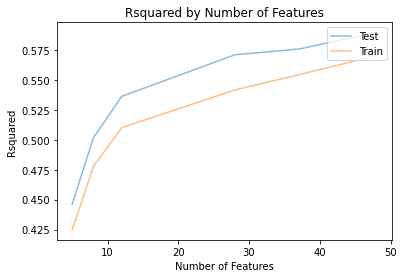

In [17]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [18]:
# Cell for your computations to answer the next question
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

48
0.5897455569799861
0.5702172143245328


In [19]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
11,host_since_2013-02-04,-108.831881,108.831881
41,room_type_Shared room,-76.429641,76.429641
31,zipcode_98133,-55.649176,55.649176
17,zipcode_98106,-52.935974,52.935974
19,zipcode_98108,-51.913652,51.913652
29,zipcode_98125,-48.546589,48.546589
33,zipcode_98144,-48.350544,48.350544
25,zipcode_98118,-47.508916,47.508916
24,zipcode_98117,-39.582420,39.582420
12,host_since_2013-08-30,39.211989,39.211989


It can be concluded that prices of listings depends upon following factors:

* The type of room chosen by a traveler plays: booking an entire property costs maximum followed by private room and shared apartment.


* Price of a listing also depends upon the number of bedrooms the property have and neighborhood of the property


* The location of listings.



# Q2: Relationship between reviews and other variables

In [20]:
import nltk

In [21]:
reviews = reviews.dropna()

from langdetect import detect

def detect_lang(sente):
    sente=str(sente)
    try:
        return detect(sente)
    except:
        return "None"

for index,row in reviews.iterrows():
    lang=detect_lang(row['comments'])
    reviews.at[index,'language'] = lang
#     print(lang)
    
#taking rows whose language is English
EngReviews=reviews[reviews.language=='en']

EngReviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,en
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,en


In [22]:
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

EngReviews['polarity_value']="Default"
EngReviews['neg']=0.0
EngReviews['pos']=0.0
EngReviews['neu']=0.0
EngReviews['compound']=0.0
for index,row in EngReviews.iterrows():
    ss = sid.polarity_scores(row['comments'])
    EngReviews.at[index,'polarity_value'] = ss
    EngReviews.at[index,'neg'] = ss['neg']
    EngReviews.at[index,'pos'] = ss['pos']
    EngReviews.at[index,'neu']= ss['neu']
    EngReviews.at[index,'compound'] = ss['compound']
EngReviews.head()

<ipython-input-23-54d47fdfbd31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EngReviews['polarity_value']="Default"
<ipython-input-23-54d47fdfbd31>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EngReviews['neg']=0.0
<ipython-input-23-54d47fdfbd31>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity_value,neg,pos,neu,compound
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,en,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp...",0.000,0.538,0.462,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,en,"{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'comp...",0.000,0.391,0.609,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",en,"{'neg': 0.043, 'neu': 0.772, 'pos': 0.185, 'co...",0.043,0.185,0.772,0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,en,"{'neg': 0.035, 'neu': 0.765, 'pos': 0.2, 'comp...",0.035,0.200,0.765,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,en,"{'neg': 0.0, 'neu': 0.655, 'pos': 0.345, 'comp...",0.000,0.345,0.655,0.9783


In [24]:
pos_reviews = EngReviews[EngReviews["pos"]>0.5]

In [25]:
neg_reviews = EngReviews[EngReviews["neg"]>0.3]

In [26]:
from nltk.corpus import stopwords
import string
import nltk
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


def word_plot(data):
    words=''
    for index,row in data.iterrows():
        words +=row['comments']

    reviews_data = nltk.word_tokenize(words)
    string_punctuation = string.punctuation
    ignoreChar = ['\r','\n','',' ',"'s",'!',',',]
    nums = ['0','1','2','3','4','5','6','7','8','9']
    
    cachedStopWords = stopwords.words("english")
    cachedStopWords.append('the')

    words_only = [''.join(c for c in s if c not in string.punctuation if c not in nums if c not in ignoreChar) for s in reviews_data]
    words_only = [s for s in words_only if s]
    comments_filtered_data=' '.join(words_only)
    comments_filtered_data = ' '.join([word.lower() for word in comments_filtered_data.split() if word not in cachedStopWords])
    
    wordcloud = WordCloud(width = 1000, height = 700).generate(comments_filtered_data)
    plt.figure(figsize=(18,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    

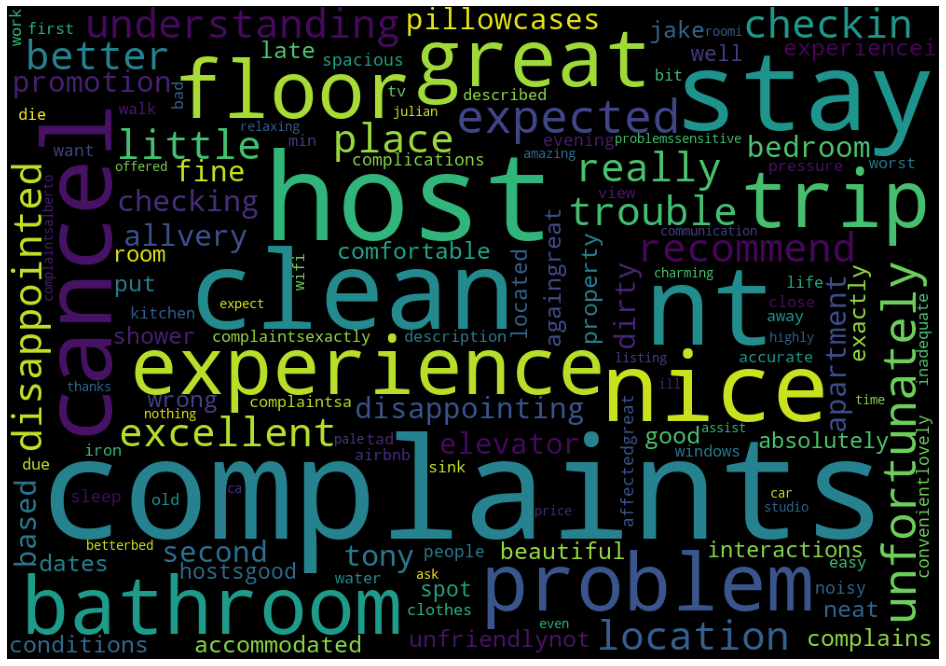

In [27]:
word_plot(neg_reviews)

It can be seen that unique words like complaints, disappointed, little, problem, trouble, which are very commonly words used when users are describing their experiences. This is making sense because the primary purpose of AirBnB is not to provide luxury hotel suites but just a convinient place to stay. 

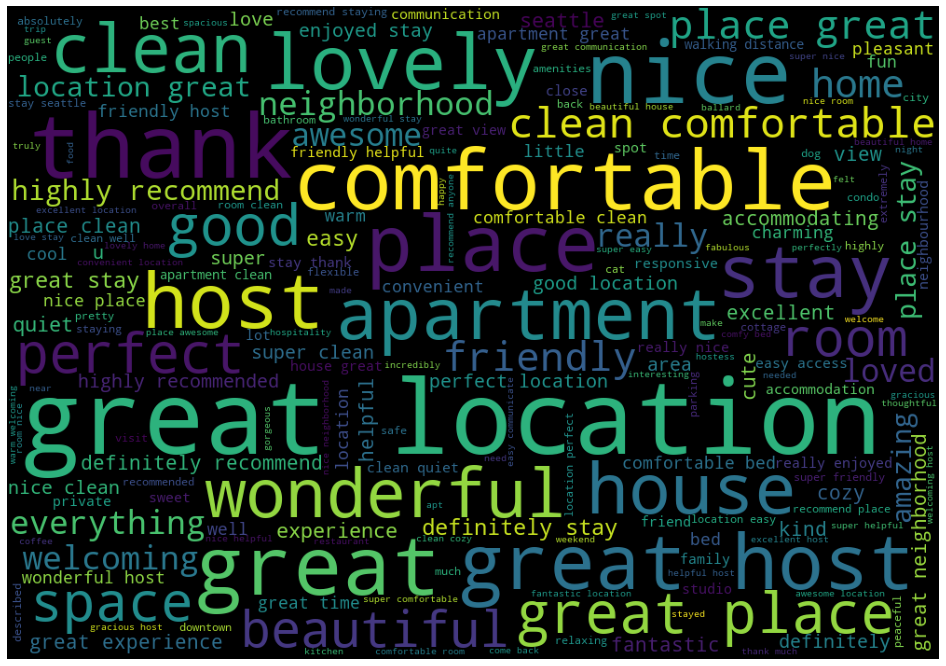

In [28]:
word_plot(pos_reviews)

In the positive reviews, it can be seen that unique words like comfortable, wonderful, great place, great location, clean, lovely, which are very commonly words used when users are describing their experiences. 



# Q3:  What are the busiest times of the year to visit Seattle? 

In [29]:
import re
#replacing NaN values with 0
calendar_DF.fillna(0, inplace=True)
calendar_DF = calendar_DF[calendar_DF.price != 0]

#Extracting prices from the table
price_c = calendar_DF['price']
prices_c=[]

for p in price_c:
    p = re.sub('[^0-9.]+','', p)
    prices_c.append(float(p))
    
#replace the price column with the new column
calendar_DF['price']=prices_c

calendar_DF = calendar_DF[calendar_DF.price >= 0]

#separating date column into day month and year
calendar_DF['Year'],calendar_DF['Month'],calendar_DF['Day']=calendar_DF['date'].str.split('-',2).str
calendar_DF.head()

<ipython-input-29-f70940fee355>:20: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  calendar_DF['Year'],calendar_DF['Month'],calendar_DF['Day']=calendar_DF['date'].str.split('-',2).str


,listing_id,date,available,price,Year,Month,Day
0,241032,2016-01-04,t,85.0,2016,01,04
1,241032,2016-01-05,t,85.0,2016,01,05
9,241032,2016-01-13,t,85.0,2016,01,13
10,241032,2016-01-14,t,85.0,2016,01,14
14,241032,2016-01-18,t,85.0,2016,01,18


In [30]:
import holidays
import datetime
import calendar
from datetime import date

In [31]:
calendar_DF['date'][1]

'2016-01-05'

In [32]:
us_holidays = holidays.US()
print(us_holidays.get(calendar_DF['date'][50]))

None


In [33]:
calendar_DF['holiday']='False'
calendar_DF['us_holidays_name']='working'
for index,row in calendar_DF.iterrows():
    sdate = datetime.date(int(row['Year']),int(row['Month']),int(row['Day']))
    vall=date(int(row['Year']),int(row['Month']),int(row['Day'])) in us_holidays
    calendar_DF.at[index,'day_Name'] = calendar.day_name[sdate.weekday()]
    calendar_DF.at[index,'holiday'] = vall
    calendar_DF.at[index,'us_holidays_name'] = us_holidays.get(sdate)
calendar_DF.head()

,listing_id,date,available,price,Year,Month,Day,week,holiday,us_holidays_name,day_Name
0,241032,2016-01-04,t,85.0,2016,01,04,default,False,None,Monday
1,241032,2016-01-05,t,85.0,2016,01,05,default,False,None,Tuesday
9,241032,2016-01-13,t,85.0,2016,01,13,default,False,None,Wednesday
10,241032,2016-01-14,t,85.0,2016,01,14,default,False,None,Thursday
14,241032,2016-01-18,t,85.0,2016,01,18,default,True,Martin Luther King Jr. Day,Monday


In [34]:
holidayPriceDF=calendar_DF.groupby('us_holidays_name').price.mean()
holidayPriceDF=holidayPriceDF.reset_index()
holidayPriceDF=holidayPriceDF.sort_values('price',ascending=[0])

holidayPriceDF.head(10)

,us_holidays_name,price
3,Independence Day,151.402362
6,Memorial Day,143.233837
4,Labor Day,142.087264
10,Veterans Day,140.070272
7,New Year's Day,138.126968
0,Christmas Day,137.974903
1,Christmas Day (Observed),137.895797
9,Thanksgiving,136.054989
8,New Year's Day (Observed),135.572767
2,Columbus Day,134.985660


In [43]:
def show_plot(x,y,dataframe):
    plt.figure(figsize=(19,10))
    ax = sns.barplot(x, y, data=dataframe,palette="Blues_d")
    if y == 'listing_id':
        y_label = "Total Number of Listings"
    elif y == 'price':
        y_label = "Average Price"
    ax.set(xlabel='US Holidays Name', ylabel = y_label)

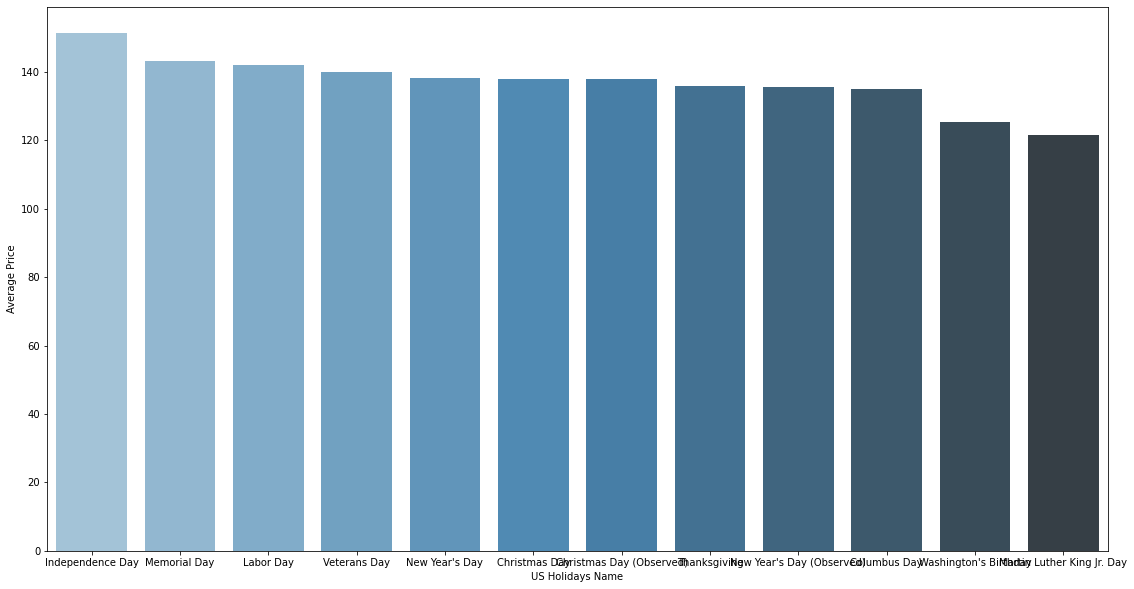

In [45]:
show_plot("us_holidays_name", "price", holidayPriceDF)

In [35]:
WeekPriceDF=calendar_DF.groupby('day_Name').price.mean()
WeekPriceDF=WeekPriceDF.reset_index()
WeekPriceDF=WeekPriceDF.sort_values('price',ascending=[0])

WeekPriceDF.head(10)

,day_Name,price
2,Saturday,143.202136
0,Friday,143.036294
4,Thursday,136.476032
3,Sunday,136.459941
1,Monday,135.676414
6,Wednesday,135.447880
5,Tuesday,135.408764


C:\Users\wenyi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


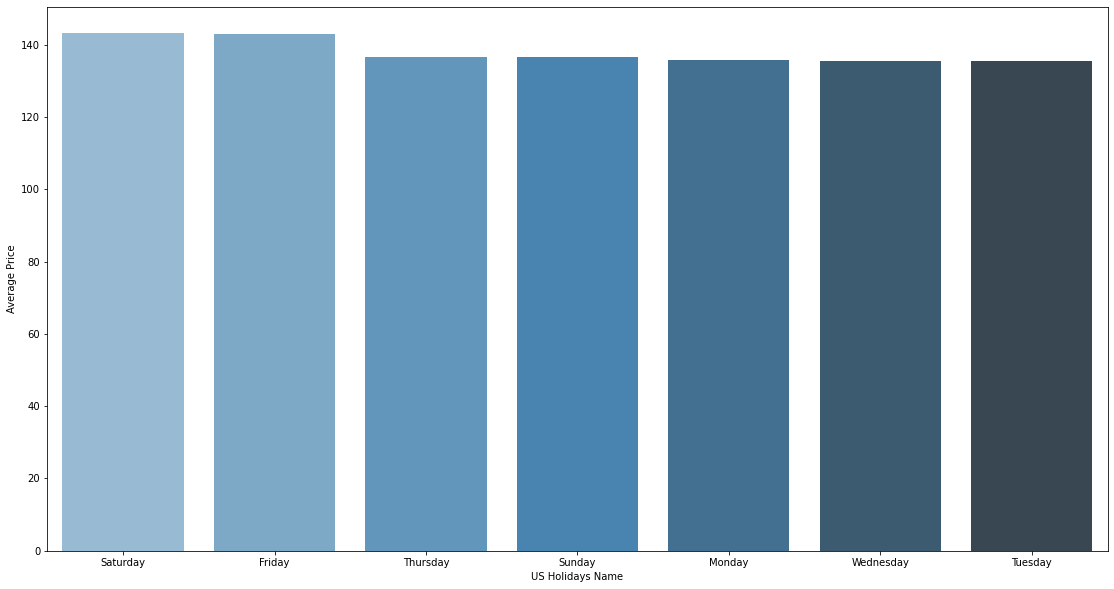

In [46]:
show_plot("day_Name", "price", WeekPriceDF)

In [41]:
MonthPriceDF=calendar_DF.groupby('Month').price.mean()
MonthPriceDF=MonthPriceDF.reset_index()
MonthPriceDF=MonthPriceDF.sort_values('price',ascending=[0])

MonthPriceDF.head(10)

,Month,price
6,07,152.094150
7,08,150.656594
5,06,147.473137
8,09,143.255949
4,05,139.538183
11,12,137.251835
9,10,137.031939
10,11,135.688738
3,04,135.097005
2,03,128.644488


C:\Users\wenyi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


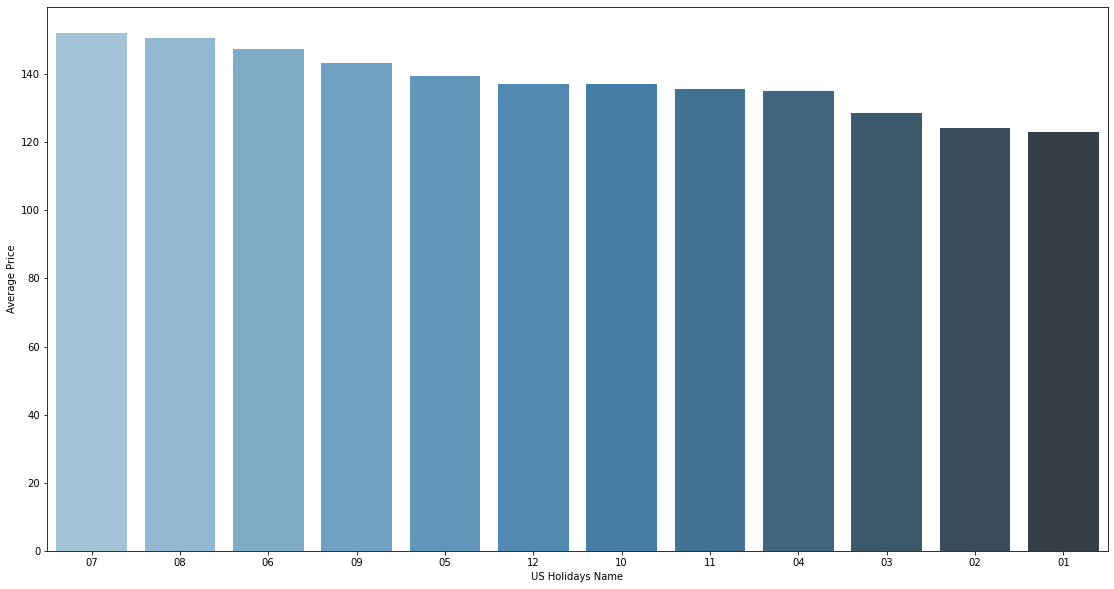

In [47]:
show_plot("Month", "price", MonthPriceDF)

If a traveler is visiting Seattle on a low budget then he/she should avoid visiting in July and August as these are the times when average price of listings are fairly high as compared to the other months. Additionally, the traveler should also avoid visiting Seattle during weekends as the prices are high compared to that of weekdays.